<a href="https://colab.research.google.com/github/alind7402/BTCPrediction/blob/main/Final_code_for_DeepAR_TransformerGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the code for the DeepAR model and Transformer model used in "Enhancing Bitcoin Price Predictions with Machine Learning Techniques" by Alex Lindquist, Mateo Sarabia, Nate Smullen, Naida Torres, Julia Tylar, and
Mohammad Meysami.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Seed 0] Epoch 1/100, Train Loss: 0.2337, Val Loss: 0.2076
[Seed 0] Epoch 2/100, Train Loss: 0.0381, Val Loss: 0.0355
[Seed 0] Epoch 3/100, Train Loss: 0.0185, Val Loss: 0.0055
[Seed 0] Epoch 4/100, Train Loss: 0.0082, Val Loss: 0.0098
[Seed 0] Epoch 5/100, Train Loss: 0.0077, Val Loss: 0.0233
[Seed 0] Epoch 6/100, Train Loss: 0.0075, Val Loss: 0.0100
[Seed 0] Epoch 7/100, Train Loss: 0.0064, Val Loss: 0.0269
[Seed 0] Epoch 8/100, Train Loss: 0.0075, Val Loss: 0.0096
[Seed 0] Epoch 9/100, Train Loss: 0.0065, Val Loss: 0.0084
[Seed 0] Epoch 10/100, Train Loss: 0.0035, Val Loss: 0.0137
[Seed 0] Epoch 11/100, Train Loss: 0.0024, Val Loss: 0.0071
[Seed 0] Epoch 12/100, Train Loss: 0.0025, Val Loss: 0.0091
[Seed 0] Epoch 13/100, Train Loss: 0.0023, Val Loss: 0.0068
Early stopping triggered for seed 0.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Seed 1] Epoch 1/100, Train Loss: 0.2332, Val Loss: 0.0120
[Seed 1] Epoch 2/100, Train Loss: 0.0418, Val Loss: 0.0077
[Seed 1] Epoch 3/100, Train Loss: 0.0134, Val Loss: 0.0169
[Seed 1] Epoch 4/100, Train Loss: 0.0083, Val Loss: 0.0109
[Seed 1] Epoch 5/100, Train Loss: 0.0075, Val Loss: 0.0109
[Seed 1] Epoch 6/100, Train Loss: 0.0052, Val Loss: 0.0331
[Seed 1] Epoch 7/100, Train Loss: 0.0062, Val Loss: 0.0224
[Seed 1] Epoch 8/100, Train Loss: 0.0044, Val Loss: 0.0389
[Seed 1] Epoch 9/100, Train Loss: 0.0026, Val Loss: 0.0202
[Seed 1] Epoch 10/100, Train Loss: 0.0023, Val Loss: 0.0308
[Seed 1] Epoch 11/100, Train Loss: 0.0021, Val Loss: 0.0194
[Seed 1] Epoch 12/100, Train Loss: 0.0023, Val Loss: 0.0260
Early stopping triggered for seed 1.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Seed 2] Epoch 1/100, Train Loss: 0.2869, Val Loss: 0.0335
[Seed 2] Epoch 2/100, Train Loss: 0.0517, Val Loss: 0.1030
[Seed 2] Epoch 3/100, Train Loss: 0.0190, Val Loss: 0.0738
[Seed 2] Epoch 4/100, Train Loss: 0.0104, Val Loss: 0.0255
[Seed 2] Epoch 5/100, Train Loss: 0.0105, Val Loss: 0.0202
[Seed 2] Epoch 6/100, Train Loss: 0.0059, Val Loss: 0.0317
[Seed 2] Epoch 7/100, Train Loss: 0.0056, Val Loss: 0.0592
[Seed 2] Epoch 8/100, Train Loss: 0.0060, Val Loss: 0.0204
[Seed 2] Epoch 9/100, Train Loss: 0.0054, Val Loss: 0.0360
[Seed 2] Epoch 10/100, Train Loss: 0.0041, Val Loss: 0.0163
[Seed 2] Epoch 11/100, Train Loss: 0.0027, Val Loss: 0.0167
[Seed 2] Epoch 12/100, Train Loss: 0.0028, Val Loss: 0.0095
[Seed 2] Epoch 13/100, Train Loss: 0.0021, Val Loss: 0.0402
[Seed 2] Epoch 14/100, Train Loss: 0.0023, Val Loss: 0.0537
[Seed 2] Epoch 15/100, Train Loss: 0.0022, Val Loss: 0.0329
[Seed 2] Epoch 16/100, Train Loss: 0.0021, Val Loss: 0.0337
[Seed 2] Epoch 17/100, Train Loss: 0.0022, Val Lo

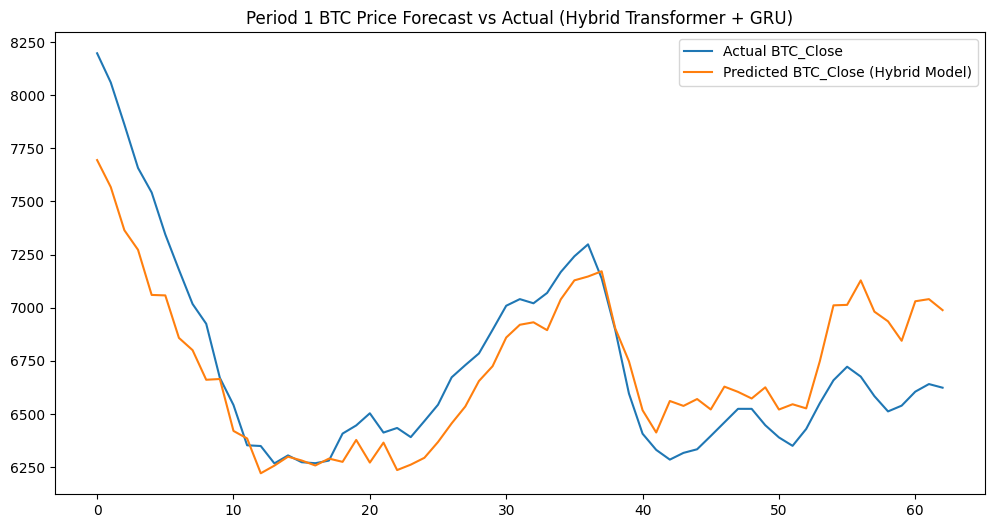

In [ ]:
# Hybrid GRU/transformer Period 1

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import date, timedelta

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df.set_index('Date', inplace=True)

# Smooth target to reduce noise
df['BTC_Close'] = df['BTC_Close'].rolling(window=3).mean().bfill()

# Feature engineering
df['BTC_Log_Return'] = np.log(df['BTC_Close'] / df['BTC_Close'].shift(1))
df['BTC_Close_lag_1'] = df['BTC_Close'].shift(1)
df['BTC_Close_roll_mean_7'] = df['BTC_Close'].rolling(window=7).mean()
df['BTC_Close_roll_std_7'] = df['BTC_Close'].rolling(window=7).std()
df['BTC_Close_roll_std_30'] = df['BTC_Close'].rolling(window=30).std()
df['Momentum_7'] = df['BTC_Close'] - df['BTC_Close'].shift(7)

# RSI (Relative Strength Index)
window = 14
delta = df['BTC_Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Time-based features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

# Forward/backward fill missing values
df = df.ffill().bfill()

# Date range
Start_day = date(2015, 8, 7)
Test_day = date(2018, 4, 1)
End_day = date(2018, 9, 30)
df = df.loc[str(Start_day):str(End_day)]

# Define target
target_col = 'BTC_Close'

# Define features
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove(target_col)

# Split data
train_end = Test_day - timedelta(days=1)
train_df = df.loc[:str(train_end)]
test_df = df.loc[str(Test_day):]

# Normalize
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(train_df[feature_cols])
y_train_scaled = scaler_y.fit_transform(train_df[[target_col]])

X_test_scaled = scaler_X.transform(test_df[feature_cols])
y_test_scaled = scaler_y.transform(test_df[[target_col]])

# Sequence creator with optional Gaussian noise
def create_sequences(X, y, seq_length, augment=False):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x_seq = X[i:i+seq_length]
        y_seq = y[i+seq_length]
        if augment:
            noise = np.random.normal(0, 0.01, size=x_seq.shape)
            x_seq += noise
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

seq_length = 120
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, seq_length, augment=True)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, seq_length, augment=False)

# Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=64, shuffle=False)

# Transformer + GRU hybrid model
class TransformerGRUForecast(nn.Module):
    def __init__(self, input_size, d_model=256, nhead=4, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerGRUForecast, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.gru = nn.GRU(d_model, 128, batch_first=True)
        self.out = nn.Sequential(
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_proj(x) + self.pos_encoder
        x = self.transformer(x)
        _, h = self.gru(x)
        return self.out(h[-1])

# Training config
input_size = len(feature_cols)
epochs = 100

ensemble_predictions = []
n_ensembles = 3
for seed in range(n_ensembles):
    torch.manual_seed(seed)
    model = TransformerGRUForecast(input_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    patience = 10
    counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X).squeeze()
            loss = loss_fn(output, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = model(batch_X).squeeze()
                loss = loss_fn(output, batch_y.squeeze())
                val_loss += loss.item()

        scheduler.step(val_loss)
        print(f"[Seed {seed}] Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), f'best_model_hybrid_{seed}.pt')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered for seed {seed}.")
                break

    model.load_state_dict(torch.load(f'best_model_hybrid_{seed}.pt'))
    model.eval()

    predictions = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_X = batch_X.to(device)
            output = model(batch_X).squeeze()
            predictions.extend(output.cpu().numpy())

    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()
    ensemble_predictions.append(predictions)

# Ensemble average
ensemble_predictions = np.array(ensemble_predictions)
predictions = ensemble_predictions.mean(axis=0)

# Actual values
actuals = scaler_y.inverse_transform(y_test.reshape(-1, 1)).squeeze()

# RMSE
rmse = math.sqrt(mean_squared_error(actuals, predictions))
print(f"\nHybrid Model Final RMSE for BTC_Close: {rmse:.4f}")

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Directional Accuracy (DA)
def directional_accuracy(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    return np.mean((np.sign(y_true_diff) == np.sign(y_pred_diff)).astype(int)) * 100

mape = mean_absolute_percentage_error(actuals, predictions)
da = directional_accuracy(actuals, predictions)

print(f"DeepAR Final MAPE for BTC_Close: {mape:.2f}%")
print(f"DeepAR Directional Accuracy for BTC_Close: {da:.2f}%")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(actuals, label='Actual BTC_Close')
plt.plot(predictions, label='Predicted BTC_Close (Hybrid Model)')
plt.legend()
plt.title("Period 1 BTC Price Forecast vs Actual (Hybrid Transformer + GRU)")
plt.show()

Epoch 1/50, Loss: 0.5367
Epoch 2/50, Loss: -0.7186
Epoch 3/50, Loss: -1.2962
Epoch 4/50, Loss: -1.5508
Epoch 5/50, Loss: -1.7400
Epoch 6/50, Loss: -0.9921
Epoch 7/50, Loss: -1.6820
Epoch 8/50, Loss: -1.8753
Epoch 9/50, Loss: -2.0719
Epoch 10/50, Loss: -2.2518
Epoch 11/50, Loss: -2.2242
Epoch 12/50, Loss: -2.0590
Epoch 13/50, Loss: -2.3534
Epoch 14/50, Loss: -1.7966
Epoch 15/50, Loss: -2.3744
Epoch 16/50, Loss: -2.0858
Epoch 17/50, Loss: -2.3898
Epoch 18/50, Loss: -2.1850
Epoch 19/50, Loss: -2.0376
Epoch 20/50, Loss: -2.4593
Epoch 21/50, Loss: -0.2049
Epoch 22/50, Loss: -0.8486
Epoch 23/50, Loss: -1.1032
Epoch 24/50, Loss: -1.5311
Epoch 25/50, Loss: -2.1224
Epoch 26/50, Loss: -2.6440
Epoch 27/50, Loss: -2.3881
Epoch 28/50, Loss: -2.1783
Epoch 29/50, Loss: -2.5986
Epoch 30/50, Loss: -2.7759
Epoch 31/50, Loss: -2.8943
Epoch 32/50, Loss: -1.9545
Epoch 33/50, Loss: -2.5787
Epoch 34/50, Loss: -2.8367
Epoch 35/50, Loss: -2.9845
Epoch 36/50, Loss: -2.4742
Epoch 37/50, Loss: -2.8275
Epoch 38/50

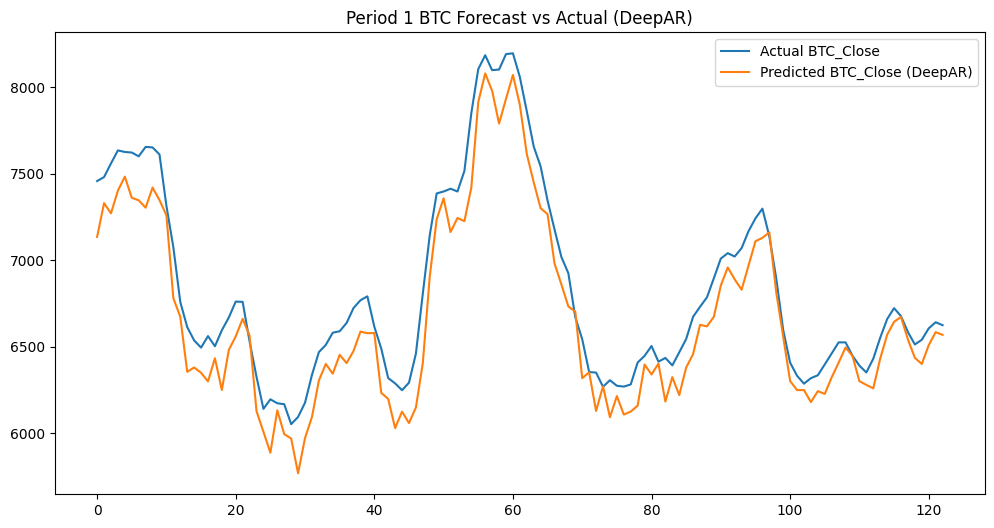

In [ ]:
# DeepAR Period 1

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import date, timedelta

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess dataset
df = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df.set_index('Date', inplace=True)
df['BTC_Close'] = df['BTC_Close'].rolling(window=3).mean().bfill()
df['BTC_Log_Return'] = np.log(df['BTC_Close'] / df['BTC_Close'].shift(1))
df['BTC_Close_lag_1'] = df['BTC_Close'].shift(1)
df['BTC_Close_roll_mean_7'] = df['BTC_Close'].rolling(window=7).mean()
df['BTC_Close_roll_std_7'] = df['BTC_Close'].rolling(window=7).std()
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)
df = df.ffill().bfill()

# Define date range and split
Start_day = date(2015, 8, 7)
Test_day = date(2018, 4, 1)
End_day = date(2018, 9, 30)
df = df.loc[str(Start_day):str(End_day)]
target_col = 'BTC_Close'
feature_cols = ['BTC_Log_Return', 'BTC_Close_lag_1', 'BTC_Close_roll_mean_7', 'BTC_Close_roll_std_7', 'day_sin', 'day_cos']

train_end = Test_day - timedelta(days=1)
train_df = df.loc[:str(train_end)]
test_df = df.loc[str(Test_day):]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(train_df[feature_cols])
y_train_scaled = scaler_y.fit_transform(train_df[[target_col]])
X_test_scaled = scaler_X.transform(test_df[feature_cols])
y_test_scaled = scaler_y.transform(test_df[[target_col]])

# Autoregressive sequence creator
def create_autoreg_sequences(X, y, seq_length):
    sequences = []
    for i in range(len(X) - seq_length):
        context_x = X[i:i+seq_length]
        context_y = y[i:i+seq_length]
        target_y = y[i+seq_length]
        sequences.append((context_x, context_y, target_y))
    return sequences

seq_length = 60
train_seq = create_autoreg_sequences(X_train_scaled, y_train_scaled, seq_length)
test_seq = create_autoreg_sequences(X_test_scaled, y_test_scaled, seq_length)

# Dataset and DataLoader
class DeepARDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        X, past_y, future_y = self.sequences[idx]
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(past_y, dtype=torch.float32).view(-1, 1),
            torch.tensor(future_y, dtype=torch.float32)
        )

train_loader = DataLoader(DeepARDataset(train_seq), batch_size=32, shuffle=True)
test_loader = DataLoader(DeepARDataset(test_seq), batch_size=32, shuffle=False)

# DeepAR model
class DeepAR(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2):
        super(DeepAR, self).__init__()
        self.lstm = nn.LSTM(input_size + 1, hidden_size, num_layers, batch_first=True)
        self.mu = nn.Linear(hidden_size, 1)
        self.sigma = nn.Linear(hidden_size, 1)

    def forward(self, x, y_history):
        if y_history.dim() == 4:
            y_history = y_history.squeeze(1)
        lstm_input = torch.cat((x, y_history), dim=-1)
        out, _ = self.lstm(lstm_input)
        h = out[:, -1, :]
        mu = self.mu(h)
        sigma = torch.exp(self.sigma(h))
        return mu, sigma

# Loss function
def gaussian_nll(mu, sigma, y, eps=1e-6):
    sigma = torch.clamp(sigma, min=eps)
    return torch.mean(0.5 * torch.log(2 * torch.pi * sigma**2) + (y - mu)**2 / (2 * sigma**2))

# Training
input_size = len(feature_cols)
model = DeepAR(input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y_hist, y in train_loader:
        x, y_hist, y = x.to(device), y_hist.to(device), y.to(device)
        optimizer.zero_grad()
        mu, sigma = model(x, y_hist)
        loss = gaussian_nll(mu.squeeze(), sigma.squeeze(), y.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Evaluation with rolling prediction
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for x, y_hist, y_true in test_loader:
        x, y_hist = x.to(device), y_hist.to(device)
        mu, sigma = model(x, y_hist)
        predictions.extend(mu.squeeze().cpu().numpy())
        actuals.extend(y_true.squeeze().cpu().numpy())

predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).squeeze()

rmse = math.sqrt(mean_squared_error(actuals, predictions))
print(f"\nDeepAR Final RMSE for BTC_Close: {rmse:.4f}")

# Evaluation metrics: MAPE and DA

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Directional Accuracy (DA)
def directional_accuracy(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    return np.mean((np.sign(y_true_diff) == np.sign(y_pred_diff)).astype(int)) * 100

mape = mean_absolute_percentage_error(actuals, predictions)
da = directional_accuracy(actuals, predictions)

print(f"DeepAR Final MAPE for BTC_Close: {mape:.2f}%")
print(f"DeepAR Directional Accuracy for BTC_Close: {da:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(actuals, label='Actual BTC_Close')
plt.plot(predictions, label='Predicted BTC_Close (DeepAR)')
plt.legend()
plt.title("Period 1 BTC Forecast vs Actual (DeepAR)")
plt.show()

<ipython-input-4-10f54d644977>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Epoch 1/50, Loss: 0.2880
Epoch 2/50, Loss: -1.0494
Epoch 3/50, Loss: -0.5749
Epoch 4/50, Loss: -0.7743
Epoch 5/50, Loss: -1.5142
Epoch 6/50, Loss: -1.8038
Epoch 7/50, Loss: -1.8785
Epoch 8/50, Loss: -2.0337
Epoch 9/50, Loss: -2.1266
Epoch 10/50, Loss: -1.5947
Epoch 11/50, Loss: -2.0887
Epoch 12/50, Loss: -0.9962
Epoch 13/50, Loss: -1.5632
Epoch 14/50, Loss: -2.0223
Epoch 15/50, Loss: -1.9990
Epoch 16/50, Loss: -1.8225
Epoch 17/50, Loss: -2.2942
Epoch 18/50, Loss: -2.0821
Epoch 19/50, Loss: -2.2590
Epoch 20/50, Loss: -2.4893
Epoch 21/50, Loss: -2.3088
Epoch 22/50, Loss: -2.5017
Epoch 23/50, Loss: -2.0969
Epoch 24/50, Loss: -2.4242
Epoch 25/50, Loss: -2.0299
Epoch 26/50, Loss: -1.9499
Epoch 27/50, Loss: -1.9256
Epoch 28/50, Loss: -2.4019
Epoch 29/50, Loss: -2.2206
Epoch 30/50, Loss: -2.4372
Epoch 31/50, Loss: -2.3387
Epoch 32/50, Loss: -2.4579
Epoch 33/50, Loss: -2.3830
Epoch 34/50, Loss: -2.2669
Epoch 35/50, Loss: -2.6676
Epoch 36/50, Loss: -2.0737
Epoch 37/50, Loss: -2.5068
Epoch 38/50

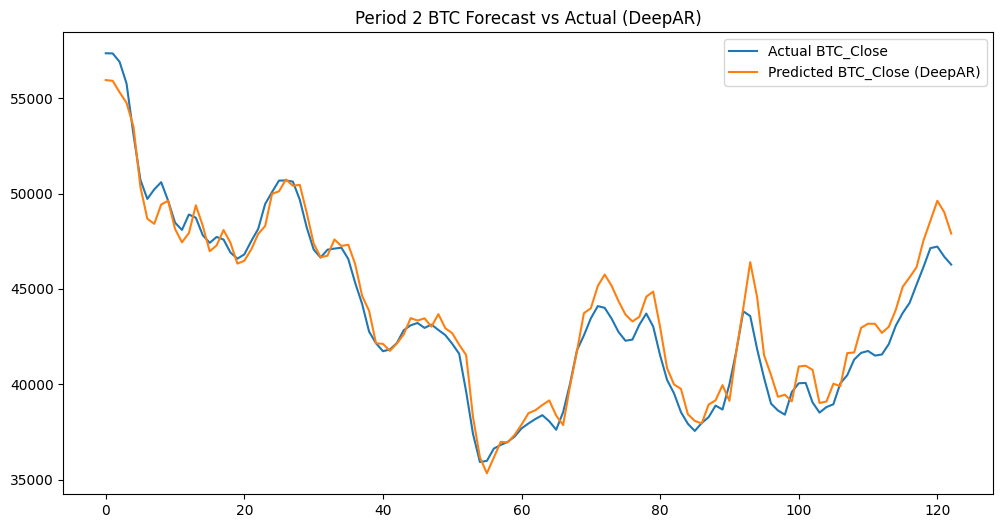

In [ ]:
# DeepAR period 2
df = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
df = df.loc[:2558, :]  # Drop NULL values after April 1st
df['Date'] = pd.to_datetime(df['Date'].str[:10], format='%Y/%m/%d')
df = df.fillna(method='ffill')
df.set_index('Date', inplace=True)

# Redefine train/test dates
Start_day = date(2018, 10, 1)
Test_day = date(2021, 10, 1)

df = df[df.index.date >= Start_day]

# Your existing feature engineering
df['BTC_Close'] = df['BTC_Close'].rolling(window=3).mean().bfill()
df['BTC_Log_Return'] = np.log(df['BTC_Close'] / df['BTC_Close'].shift(1))
df['BTC_Close_lag_1'] = df['BTC_Close'].shift(1)
df['BTC_Close_roll_mean_7'] = df['BTC_Close'].rolling(window=7).mean()
df['BTC_Close_roll_std_7'] = df['BTC_Close'].rolling(window=7).std()
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)
df = df.ffill().bfill()

# Train/Test Split Period 2
train_end = Test_day - timedelta(days=1)
train_df = df.loc[:str(train_end)]
test_df = df.loc[str(Test_day):]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(train_df[feature_cols])
y_train_scaled = scaler_y.fit_transform(train_df[[target_col]])
X_test_scaled = scaler_X.transform(test_df[feature_cols])
y_test_scaled = scaler_y.transform(test_df[[target_col]])

# Autoregressive sequence creator
def create_autoreg_sequences(X, y, seq_length):
    sequences = []
    for i in range(len(X) - seq_length):
        context_x = X[i:i+seq_length]
        context_y = y[i:i+seq_length]
        target_y = y[i+seq_length]
        sequences.append((context_x, context_y, target_y))
    return sequences

seq_length = 60
train_seq = create_autoreg_sequences(X_train_scaled, y_train_scaled, seq_length)
test_seq = create_autoreg_sequences(X_test_scaled, y_test_scaled, seq_length)

# Dataset and DataLoader
class DeepARDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        X, past_y, future_y = self.sequences[idx]
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(past_y, dtype=torch.float32).view(-1, 1),
            torch.tensor(future_y, dtype=torch.float32)
        )

train_loader = DataLoader(DeepARDataset(train_seq), batch_size=32, shuffle=True)
test_loader = DataLoader(DeepARDataset(test_seq), batch_size=32, shuffle=False)

# DeepAR model
class DeepAR(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2):
        super(DeepAR, self).__init__()
        self.lstm = nn.LSTM(input_size + 1, hidden_size, num_layers, batch_first=True)
        self.mu = nn.Linear(hidden_size, 1)
        self.sigma = nn.Linear(hidden_size, 1)

    def forward(self, x, y_history):
        if y_history.dim() == 4:
            y_history = y_history.squeeze(1)
        lstm_input = torch.cat((x, y_history), dim=-1)
        out, _ = self.lstm(lstm_input)
        h = out[:, -1, :]
        mu = self.mu(h)
        sigma = torch.exp(self.sigma(h))
        return mu, sigma

# Loss function
def gaussian_nll(mu, sigma, y, eps=1e-6):
    sigma = torch.clamp(sigma, min=eps)
    return torch.mean(0.5 * torch.log(2 * torch.pi * sigma**2) + (y - mu)**2 / (2 * sigma**2))

# Training
input_size = len(feature_cols)
model = DeepAR(input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y_hist, y in train_loader:
        x, y_hist, y = x.to(device), y_hist.to(device), y.to(device)
        optimizer.zero_grad()
        mu, sigma = model(x, y_hist)
        loss = gaussian_nll(mu.squeeze(), sigma.squeeze(), y.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Evaluation with rolling prediction
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for x, y_hist, y_true in test_loader:
        x, y_hist = x.to(device), y_hist.to(device)
        mu, sigma = model(x, y_hist)
        predictions.extend(mu.squeeze().cpu().numpy())
        actuals.extend(y_true.squeeze().cpu().numpy())

predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).squeeze()

rmse = math.sqrt(mean_squared_error(actuals, predictions))
print(f"\nDeepAR Final RMSE for BTC_Close: {rmse:.4f}")

# Evaluation metrics: MAPE and DA

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Directional Accuracy (DA)
def directional_accuracy(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    return np.mean((np.sign(y_true_diff) == np.sign(y_pred_diff)).astype(int)) * 100

mape = mean_absolute_percentage_error(actuals, predictions)
da = directional_accuracy(actuals, predictions)

print(f"DeepAR Final MAPE for BTC_Close: {mape:.2f}%")
print(f"DeepAR Directional Accuracy for BTC_Close: {da:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(actuals, label='Actual BTC_Close')
plt.plot(predictions, label='Predicted BTC_Close (DeepAR)')
plt.legend()
plt.title("Period 2 BTC Forecast vs Actual (DeepAR)")
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Seed 0] Epoch 1/100, Train Loss: 0.1506, Val Loss: 0.0151
[Seed 0] Epoch 2/100, Train Loss: 0.0242, Val Loss: 0.0298
[Seed 0] Epoch 3/100, Train Loss: 0.0069, Val Loss: 0.0497
[Seed 0] Epoch 4/100, Train Loss: 0.0040, Val Loss: 0.0274
[Seed 0] Epoch 5/100, Train Loss: 0.0031, Val Loss: 0.0060
[Seed 0] Epoch 6/100, Train Loss: 0.0022, Val Loss: 0.0071
[Seed 0] Epoch 7/100, Train Loss: 0.0020, Val Loss: 0.0034
[Seed 0] Epoch 8/100, Train Loss: 0.0022, Val Loss: 0.0045
[Seed 0] Epoch 9/100, Train Loss: 0.0019, Val Loss: 0.0037
[Seed 0] Epoch 10/100, Train Loss: 0.0015, Val Loss: 0.0107
[Seed 0] Epoch 11/100, Train Loss: 0.0019, Val Loss: 0.0068
[Seed 0] Epoch 12/100, Train Loss: 0.0019, Val Loss: 0.0036
[Seed 0] Epoch 13/100, Train Loss: 0.0018, Val Loss: 0.0048
[Seed 0] Epoch 14/100, Train Loss: 0.0012, Val Loss: 0.0066
[Seed 0] Epoch 15/100, Train Loss: 0.0010, Val Loss: 0.0041
[Seed 0] Epoch 16/100, Train Loss: 0.0010, Val Loss: 0.0051
[Seed 0] Epoch 17/100, Train Loss: 0.0009, Val Lo

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Seed 1] Epoch 1/100, Train Loss: 0.1546, Val Loss: 0.0211
[Seed 1] Epoch 2/100, Train Loss: 0.0126, Val Loss: 0.0144
[Seed 1] Epoch 3/100, Train Loss: 0.0046, Val Loss: 0.0092
[Seed 1] Epoch 4/100, Train Loss: 0.0033, Val Loss: 0.0079
[Seed 1] Epoch 5/100, Train Loss: 0.0030, Val Loss: 0.0067
[Seed 1] Epoch 6/100, Train Loss: 0.0028, Val Loss: 0.0122
[Seed 1] Epoch 7/100, Train Loss: 0.0022, Val Loss: 0.0105
[Seed 1] Epoch 8/100, Train Loss: 0.0020, Val Loss: 0.0130
[Seed 1] Epoch 9/100, Train Loss: 0.0025, Val Loss: 0.0081
[Seed 1] Epoch 10/100, Train Loss: 0.0019, Val Loss: 0.0120
[Seed 1] Epoch 11/100, Train Loss: 0.0024, Val Loss: 0.0122
[Seed 1] Epoch 12/100, Train Loss: 0.0018, Val Loss: 0.0099
[Seed 1] Epoch 13/100, Train Loss: 0.0012, Val Loss: 0.0097
[Seed 1] Epoch 14/100, Train Loss: 0.0011, Val Loss: 0.0096
[Seed 1] Epoch 15/100, Train Loss: 0.0011, Val Loss: 0.0097
Early stopping triggered for seed 1.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Seed 2] Epoch 1/100, Train Loss: 0.2117, Val Loss: 0.0774
[Seed 2] Epoch 2/100, Train Loss: 0.0501, Val Loss: 0.0326
[Seed 2] Epoch 3/100, Train Loss: 0.0206, Val Loss: 0.0406
[Seed 2] Epoch 4/100, Train Loss: 0.0057, Val Loss: 0.0258
[Seed 2] Epoch 5/100, Train Loss: 0.0037, Val Loss: 0.0129
[Seed 2] Epoch 6/100, Train Loss: 0.0030, Val Loss: 0.0146
[Seed 2] Epoch 7/100, Train Loss: 0.0032, Val Loss: 0.0149
[Seed 2] Epoch 8/100, Train Loss: 0.0027, Val Loss: 0.0315
[Seed 2] Epoch 9/100, Train Loss: 0.0029, Val Loss: 0.0526
[Seed 2] Epoch 10/100, Train Loss: 0.0022, Val Loss: 0.0339
[Seed 2] Epoch 11/100, Train Loss: 0.0023, Val Loss: 0.0393
[Seed 2] Epoch 12/100, Train Loss: 0.0018, Val Loss: 0.0177
[Seed 2] Epoch 13/100, Train Loss: 0.0014, Val Loss: 0.0258
[Seed 2] Epoch 14/100, Train Loss: 0.0012, Val Loss: 0.0247
[Seed 2] Epoch 15/100, Train Loss: 0.0012, Val Loss: 0.0253
Early stopping triggered for seed 2.

Hybrid Model Final RMSE for BTC_Close: 1117.6010
DeepAR Final MAPE for 

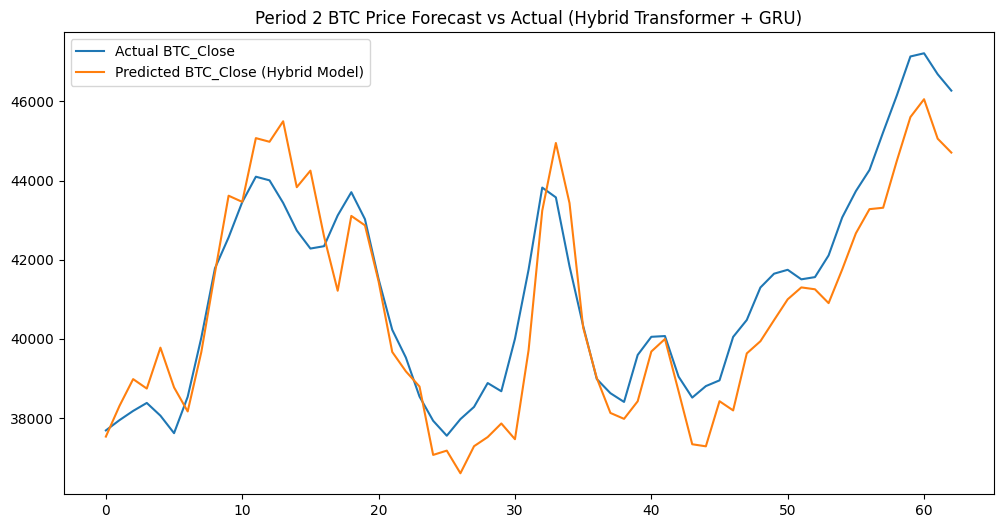

In [ ]:
# Hybrid GRU/transformer Period 2

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import date, timedelta

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df.set_index('Date', inplace=True)

# Smooth target to reduce noise
df['BTC_Close'] = df['BTC_Close'].rolling(window=3).mean().bfill()

# Feature engineering
df['BTC_Log_Return'] = np.log(df['BTC_Close'] / df['BTC_Close'].shift(1))
df['BTC_Close_lag_1'] = df['BTC_Close'].shift(1)
df['BTC_Close_roll_mean_7'] = df['BTC_Close'].rolling(window=7).mean()
df['BTC_Close_roll_std_7'] = df['BTC_Close'].rolling(window=7).std()
df['BTC_Close_roll_std_30'] = df['BTC_Close'].rolling(window=30).std()
df['Momentum_7'] = df['BTC_Close'] - df['BTC_Close'].shift(7)

# RSI (Relative Strength Index)
window = 14
delta = df['BTC_Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Time-based features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

# Forward/backward fill missing values
df = df.ffill().bfill()

# Date range
Start_day = date(2018, 10, 1)
Test_day = date(2021, 10, 1)
End_day = date(2022, 4, 1)
df = df.loc[str(Start_day):str(End_day)]

# Define target
target_col = 'BTC_Close'

# Define features
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove(target_col)

# Split data
train_end = Test_day - timedelta(days=1)
train_df = df.loc[:str(train_end)]
test_df = df.loc[str(Test_day):]

# Normalize
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(train_df[feature_cols])
y_train_scaled = scaler_y.fit_transform(train_df[[target_col]])

X_test_scaled = scaler_X.transform(test_df[feature_cols])
y_test_scaled = scaler_y.transform(test_df[[target_col]])

# Sequence creator with optional Gaussian noise
def create_sequences(X, y, seq_length, augment=False):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x_seq = X[i:i+seq_length]
        y_seq = y[i+seq_length]
        if augment:
            noise = np.random.normal(0, 0.01, size=x_seq.shape)
            x_seq += noise
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

seq_length = 120
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, seq_length, augment=True)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, seq_length, augment=False)

# Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=64, shuffle=False)

# Transformer + GRU hybrid model
class TransformerGRUForecast(nn.Module):
    def __init__(self, input_size, d_model=256, nhead=4, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerGRUForecast, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.gru = nn.GRU(d_model, 128, batch_first=True)
        self.out = nn.Sequential(
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_proj(x) + self.pos_encoder
        x = self.transformer(x)
        _, h = self.gru(x)
        return self.out(h[-1])

# Training config
input_size = len(feature_cols)
epochs = 100

ensemble_predictions = []
n_ensembles = 3
for seed in range(n_ensembles):
    torch.manual_seed(seed)
    model = TransformerGRUForecast(input_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    patience = 10
    counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X).squeeze()
            loss = loss_fn(output, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = model(batch_X).squeeze()
                loss = loss_fn(output, batch_y.squeeze())
                val_loss += loss.item()

        scheduler.step(val_loss)
        print(f"[Seed {seed}] Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), f'best_model_hybrid_{seed}.pt')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered for seed {seed}.")
                break

    model.load_state_dict(torch.load(f'best_model_hybrid_{seed}.pt'))
    model.eval()

    predictions = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_X = batch_X.to(device)
            output = model(batch_X).squeeze()
            predictions.extend(output.cpu().numpy())

    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()
    ensemble_predictions.append(predictions)

# Ensemble average
ensemble_predictions = np.array(ensemble_predictions)
predictions = ensemble_predictions.mean(axis=0)

# Actual values
actuals = scaler_y.inverse_transform(y_test.reshape(-1, 1)).squeeze()

# RMSE
rmse = math.sqrt(mean_squared_error(actuals, predictions))
print(f"\nHybrid Model Final RMSE for BTC_Close: {rmse:.4f}")

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Directional Accuracy (DA)
def directional_accuracy(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    return np.mean((np.sign(y_true_diff) == np.sign(y_pred_diff)).astype(int)) * 100

mape = mean_absolute_percentage_error(actuals, predictions)
da = directional_accuracy(actuals, predictions)

print(f"DeepAR Final MAPE for BTC_Close: {mape:.2f}%")
print(f"DeepAR Directional Accuracy for BTC_Close: {da:.2f}%")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(actuals, label='Actual BTC_Close')
plt.plot(predictions, label='Predicted BTC_Close (Hybrid Model)')
plt.legend()
plt.title("Period 2 BTC Price Forecast vs Actual (Hybrid Transformer + GRU)")
plt.show()

<ipython-input-11-5cebc3d1d69c>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Epoch 1/50, Loss: -0.5174
Epoch 2/50, Loss: -1.0016
Epoch 3/50, Loss: -1.7373
Epoch 4/50, Loss: -1.7529
Epoch 5/50, Loss: -1.6348
Epoch 6/50, Loss: -1.7049
Epoch 7/50, Loss: -1.9738
Epoch 8/50, Loss: -1.6305
Epoch 9/50, Loss: -2.4286
Epoch 10/50, Loss: -2.4557
Epoch 11/50, Loss: -2.4925
Epoch 12/50, Loss: -2.0331
Epoch 13/50, Loss: -2.4712
Epoch 14/50, Loss: -2.4098
Epoch 15/50, Loss: -2.5684
Epoch 16/50, Loss: -2.3472
Epoch 17/50, Loss: -2.6494
Epoch 18/50, Loss: -2.7107
Epoch 19/50, Loss: -2.4778
Epoch 20/50, Loss: -2.7236
Epoch 21/50, Loss: -2.4553
Epoch 22/50, Loss: -2.7647
Epoch 23/50, Loss: -2.7636
Epoch 24/50, Loss: -2.0249
Epoch 25/50, Loss: -2.7652
Epoch 26/50, Loss: -2.8998
Epoch 27/50, Loss: -2.7427
Epoch 28/50, Loss: -2.6694
Epoch 29/50, Loss: -2.6526
Epoch 30/50, Loss: -2.8159
Epoch 31/50, Loss: -2.7017
Epoch 32/50, Loss: -2.9173
Epoch 33/50, Loss: -2.8082
Epoch 34/50, Loss: -2.8113
Epoch 35/50, Loss: -2.9011
Epoch 36/50, Loss: -2.4646
Epoch 37/50, Loss: -2.6354
Epoch 38/5

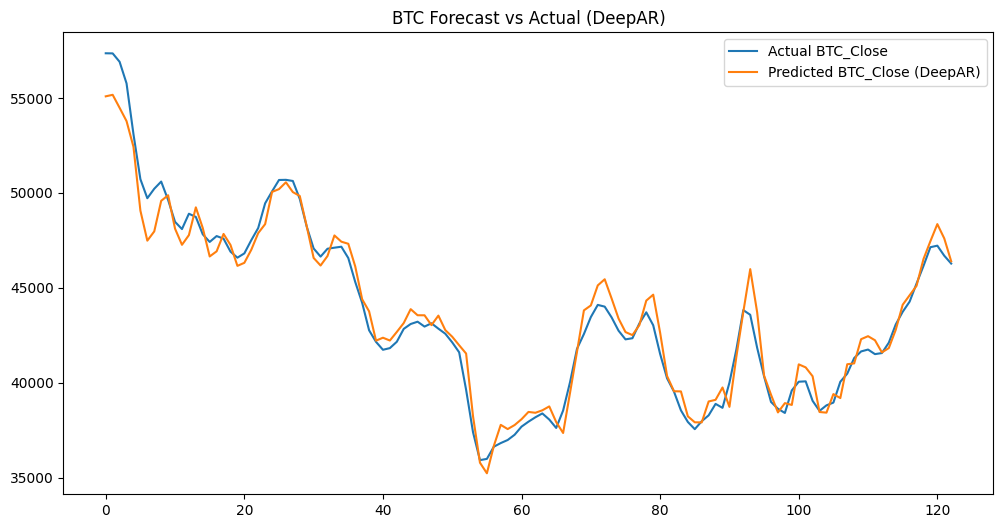

In [ ]:
# DeepAR BOTH periods
# Load dataset with full historical coverage (both Period 1 and Period 2)
df = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
df = df.loc[:2558, :]  # Trim to match data used in the original paper
df['Date'] = pd.to_datetime(df['Date'].str[:10], format='%Y/%m/%d')
df = df.fillna(method='ffill')
df.set_index('Date', inplace=True)

# Full date range covering both Period 1 and Period 2
Start_day = date(2015, 3, 31)
Test_day = date(2021, 10, 1)  # Same test split as in the original paper
End_day = date(2022, 4, 1)

df = df[(df.index.date >= Start_day) & (df.index.date <= End_day)]

# Your original feature engineering (unchanged)
df['BTC_Close'] = df['BTC_Close'].rolling(window=3).mean().bfill()
df['BTC_Log_Return'] = np.log(df['BTC_Close'] / df['BTC_Close'].shift(1))
df['BTC_Close_lag_1'] = df['BTC_Close'].shift(1)
df['BTC_Close_roll_mean_7'] = df['BTC_Close'].rolling(window=7).mean()
df['BTC_Close_roll_std_7'] = df['BTC_Close'].rolling(window=7).std()
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)
df = df.ffill().bfill()

# Define training and testing sets using full history
train_end = Test_day - timedelta(days=1)
train_df = df.loc[:str(train_end)]
test_df = df.loc[str(Test_day):]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(train_df[feature_cols])
y_train_scaled = scaler_y.fit_transform(train_df[[target_col]])
X_test_scaled = scaler_X.transform(test_df[feature_cols])
y_test_scaled = scaler_y.transform(test_df[[target_col]])

# Autoregressive sequence creator
def create_autoreg_sequences(X, y, seq_length):
    sequences = []
    for i in range(len(X) - seq_length):
        context_x = X[i:i+seq_length]
        context_y = y[i:i+seq_length]
        target_y = y[i+seq_length]
        sequences.append((context_x, context_y, target_y))
    return sequences

seq_length = 60
train_seq = create_autoreg_sequences(X_train_scaled, y_train_scaled, seq_length)
test_seq = create_autoreg_sequences(X_test_scaled, y_test_scaled, seq_length)

# Dataset and DataLoader
class DeepARDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        X, past_y, future_y = self.sequences[idx]
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(past_y, dtype=torch.float32).view(-1, 1),
            torch.tensor(future_y, dtype=torch.float32)
        )

train_loader = DataLoader(DeepARDataset(train_seq), batch_size=32, shuffle=True)
test_loader = DataLoader(DeepARDataset(test_seq), batch_size=32, shuffle=False)

# DeepAR model
class DeepAR(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2):
        super(DeepAR, self).__init__()
        self.lstm = nn.LSTM(input_size + 1, hidden_size, num_layers, batch_first=True)
        self.mu = nn.Linear(hidden_size, 1)
        self.sigma = nn.Linear(hidden_size, 1)

    def forward(self, x, y_history):
        if y_history.dim() == 4:
            y_history = y_history.squeeze(1)
        lstm_input = torch.cat((x, y_history), dim=-1)
        out, _ = self.lstm(lstm_input)
        h = out[:, -1, :]
        mu = self.mu(h)
        sigma = torch.exp(self.sigma(h))
        return mu, sigma

# Loss function
def gaussian_nll(mu, sigma, y, eps=1e-6):
    sigma = torch.clamp(sigma, min=eps)
    return torch.mean(0.5 * torch.log(2 * torch.pi * sigma**2) + (y - mu)**2 / (2 * sigma**2))

# Training
input_size = len(feature_cols)
model = DeepAR(input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y_hist, y in train_loader:
        x, y_hist, y = x.to(device), y_hist.to(device), y.to(device)
        optimizer.zero_grad()
        mu, sigma = model(x, y_hist)
        loss = gaussian_nll(mu.squeeze(), sigma.squeeze(), y.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Evaluation with rolling prediction
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for x, y_hist, y_true in test_loader:
        x, y_hist = x.to(device), y_hist.to(device)
        mu, sigma = model(x, y_hist)
        predictions.extend(mu.squeeze().cpu().numpy())
        actuals.extend(y_true.squeeze().cpu().numpy())

predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).squeeze()

rmse = math.sqrt(mean_squared_error(actuals, predictions))
print(f"\nDeepAR Final RMSE for BTC_Close: {rmse:.4f}")

# Evaluation metrics: MAPE and DA

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Directional Accuracy (DA)
def directional_accuracy(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    return np.mean((np.sign(y_true_diff) == np.sign(y_pred_diff)).astype(int)) * 100

mape = mean_absolute_percentage_error(actuals, predictions)
da = directional_accuracy(actuals, predictions)

print(f"DeepAR Final MAPE for BTC_Close: {mape:.2f}%")
print(f"DeepAR Directional Accuracy for BTC_Close: {da:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(actuals, label='Actual BTC_Close')
plt.plot(predictions, label='Predicted BTC_Close (DeepAR)')
plt.legend()
plt.title("BTC Forecast vs Actual (DeepAR)")
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Seed 0] Epoch 1/100, Train Loss: 0.2329, Val Loss: 0.2313
[Seed 0] Epoch 2/100, Train Loss: 0.0395, Val Loss: 0.0301
[Seed 0] Epoch 3/100, Train Loss: 0.0199, Val Loss: 0.0039
[Seed 0] Epoch 4/100, Train Loss: 0.0086, Val Loss: 0.0190
[Seed 0] Epoch 5/100, Train Loss: 0.0071, Val Loss: 0.0044
[Seed 0] Epoch 6/100, Train Loss: 0.0059, Val Loss: 0.0138
[Seed 0] Epoch 7/100, Train Loss: 0.0055, Val Loss: 0.0164
[Seed 0] Epoch 8/100, Train Loss: 0.0072, Val Loss: 0.0044
[Seed 0] Epoch 9/100, Train Loss: 0.0082, Val Loss: 0.0392
[Seed 0] Epoch 10/100, Train Loss: 0.0034, Val Loss: 0.0123
[Seed 0] Epoch 11/100, Train Loss: 0.0026, Val Loss: 0.0161
[Seed 0] Epoch 12/100, Train Loss: 0.0026, Val Loss: 0.0073
[Seed 0] Epoch 13/100, Train Loss: 0.0024, Val Loss: 0.0075
Early stopping triggered for seed 0.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Seed 1] Epoch 1/100, Train Loss: 0.2349, Val Loss: 0.0108
[Seed 1] Epoch 2/100, Train Loss: 0.0426, Val Loss: 0.0075
[Seed 1] Epoch 3/100, Train Loss: 0.0140, Val Loss: 0.0077
[Seed 1] Epoch 4/100, Train Loss: 0.0073, Val Loss: 0.0188
[Seed 1] Epoch 5/100, Train Loss: 0.0061, Val Loss: 0.0100
[Seed 1] Epoch 6/100, Train Loss: 0.0051, Val Loss: 0.0342
[Seed 1] Epoch 7/100, Train Loss: 0.0050, Val Loss: 0.0336
[Seed 1] Epoch 8/100, Train Loss: 0.0047, Val Loss: 0.0188
[Seed 1] Epoch 9/100, Train Loss: 0.0027, Val Loss: 0.0066
[Seed 1] Epoch 10/100, Train Loss: 0.0022, Val Loss: 0.0117
[Seed 1] Epoch 11/100, Train Loss: 0.0021, Val Loss: 0.0087
[Seed 1] Epoch 12/100, Train Loss: 0.0022, Val Loss: 0.0113
[Seed 1] Epoch 13/100, Train Loss: 0.0018, Val Loss: 0.0118
[Seed 1] Epoch 14/100, Train Loss: 0.0017, Val Loss: 0.0138
[Seed 1] Epoch 15/100, Train Loss: 0.0016, Val Loss: 0.0177
[Seed 1] Epoch 16/100, Train Loss: 0.0015, Val Loss: 0.0175
[Seed 1] Epoch 17/100, Train Loss: 0.0018, Val Lo

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Seed 2] Epoch 1/100, Train Loss: 0.2847, Val Loss: 0.0300
[Seed 2] Epoch 2/100, Train Loss: 0.0497, Val Loss: 0.1161
[Seed 2] Epoch 3/100, Train Loss: 0.0186, Val Loss: 0.0904
[Seed 2] Epoch 4/100, Train Loss: 0.0097, Val Loss: 0.0499
[Seed 2] Epoch 5/100, Train Loss: 0.0087, Val Loss: 0.0246
[Seed 2] Epoch 6/100, Train Loss: 0.0057, Val Loss: 0.0220
[Seed 2] Epoch 7/100, Train Loss: 0.0060, Val Loss: 0.0749
[Seed 2] Epoch 8/100, Train Loss: 0.0055, Val Loss: 0.0302
[Seed 2] Epoch 9/100, Train Loss: 0.0051, Val Loss: 0.0287
[Seed 2] Epoch 10/100, Train Loss: 0.0052, Val Loss: 0.0085
[Seed 2] Epoch 11/100, Train Loss: 0.0037, Val Loss: 0.0134
[Seed 2] Epoch 12/100, Train Loss: 0.0022, Val Loss: 0.0105
[Seed 2] Epoch 13/100, Train Loss: 0.0019, Val Loss: 0.0180
[Seed 2] Epoch 14/100, Train Loss: 0.0020, Val Loss: 0.0287
[Seed 2] Epoch 15/100, Train Loss: 0.0030, Val Loss: 0.0195
[Seed 2] Epoch 16/100, Train Loss: 0.0023, Val Loss: 0.0114
[Seed 2] Epoch 17/100, Train Loss: 0.0015, Val Lo

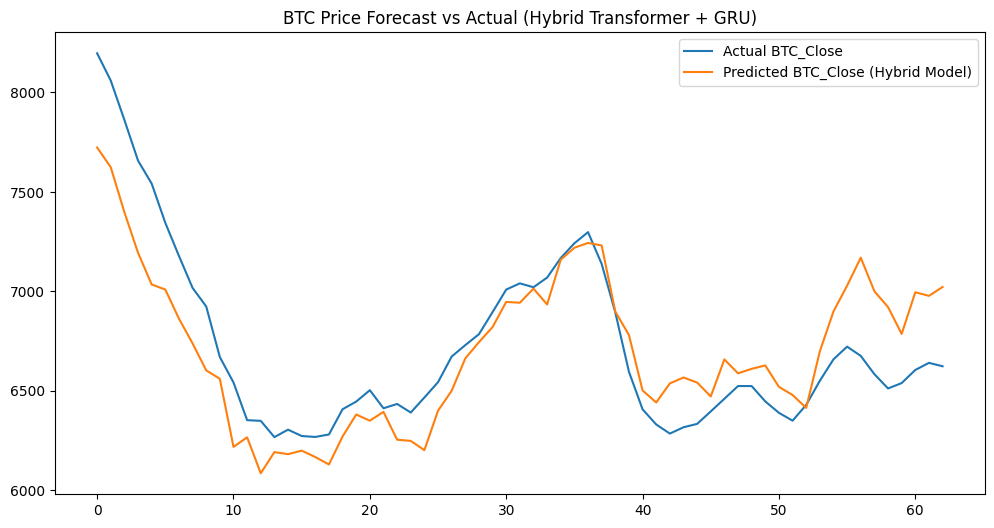

In [ ]:
# Hybrid GRU/transformer, testing adding clark

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import date, timedelta

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df.set_index('Date', inplace=True)

# Smooth target to reduce noise
df['BTC_Close'] = df['BTC_Close'].rolling(window=3).mean().bfill()

# Feature engineering
df['BTC_Log_Return'] = np.log(df['BTC_Close'] / df['BTC_Close'].shift(1))
df['BTC_Close_lag_1'] = df['BTC_Close'].shift(1)
df['BTC_Close_roll_mean_7'] = df['BTC_Close'].rolling(window=7).mean()
df['BTC_Close_roll_std_7'] = df['BTC_Close'].rolling(window=7).std()
df['BTC_Close_roll_std_30'] = df['BTC_Close'].rolling(window=30).std()
df['Momentum_7'] = df['BTC_Close'] - df['BTC_Close'].shift(7)

# RSI (Relative Strength Index)
window = 14
delta = df['BTC_Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Time-based features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

# Forward/backward fill missing values
df = df.ffill().bfill()

# Date range
Start_day = date(2015, 8, 7)
Test_day = date(2018, 4, 1)
End_day = date(2018, 9, 30)
df = df.loc[str(Start_day):str(End_day)]

# Define target
target_col = 'BTC_Close'

# Define features
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove(target_col)

# Split data
train_end = Test_day - timedelta(days=1)
train_df = df.loc[:str(train_end)]
test_df = df.loc[str(Test_day):]

# Normalize
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(train_df[feature_cols])
y_train_scaled = scaler_y.fit_transform(train_df[[target_col]])

X_test_scaled = scaler_X.transform(test_df[feature_cols])
y_test_scaled = scaler_y.transform(test_df[[target_col]])

# Sequence creator with optional Gaussian noise
def create_sequences(X, y, seq_length, augment=False):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x_seq = X[i:i+seq_length]
        y_seq = y[i+seq_length]
        if augment:
            noise = np.random.normal(0, 0.01, size=x_seq.shape)
            x_seq += noise
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

seq_length = 120
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, seq_length, augment=True)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, seq_length, augment=False)

# Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=64, shuffle=False)

# Transformer + GRU hybrid model
class TransformerGRUForecast(nn.Module):
    def __init__(self, input_size, d_model=256, nhead=4, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerGRUForecast, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.gru = nn.GRU(d_model, 128, batch_first=True)
        self.out = nn.Sequential(
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_proj(x) + self.pos_encoder
        x = self.transformer(x)
        _, h = self.gru(x)
        return self.out(h[-1])

# Training config
input_size = len(feature_cols)
epochs = 100

ensemble_predictions = []
n_ensembles = 3
for seed in range(n_ensembles):
    torch.manual_seed(seed)
    model = TransformerGRUForecast(input_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    patience = 10
    counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X).squeeze()
            loss = loss_fn(output, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = model(batch_X).squeeze()
                loss = loss_fn(output, batch_y.squeeze())
                val_loss += loss.item()

        scheduler.step(val_loss)
        print(f"[Seed {seed}] Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), f'best_model_hybrid_{seed}.pt')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered for seed {seed}.")
                break

    model.load_state_dict(torch.load(f'best_model_hybrid_{seed}.pt'))
    model.eval()

    predictions = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_X = batch_X.to(device)
            output = model(batch_X).squeeze()
            predictions.extend(output.cpu().numpy())

    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()
    ensemble_predictions.append(predictions)

# Ensemble average
ensemble_predictions = np.array(ensemble_predictions)
predictions = ensemble_predictions.mean(axis=0)

# Actual values
actuals = scaler_y.inverse_transform(y_test.reshape(-1, 1)).squeeze()

# RMSE
rmse = math.sqrt(mean_squared_error(actuals, predictions))
print(f"\nHybrid Model Final RMSE for BTC_Close: {rmse:.4f}")

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Directional Accuracy (DA)
def directional_accuracy(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    return np.mean((np.sign(y_true_diff) == np.sign(y_pred_diff)).astype(int)) * 100

mape = mean_absolute_percentage_error(actuals, predictions)
da = directional_accuracy(actuals, predictions)

print(f"DeepAR Final MAPE for BTC_Close: {mape:.2f}%")
print(f"DeepAR Directional Accuracy for BTC_Close: {da:.2f}%")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(actuals, label='Actual BTC_Close')
plt.plot(predictions, label='Predicted BTC_Close (Hybrid Model)')
plt.legend()
plt.title("BTC Price Forecast vs Actual (Hybrid Transformer + GRU)")
plt.show()

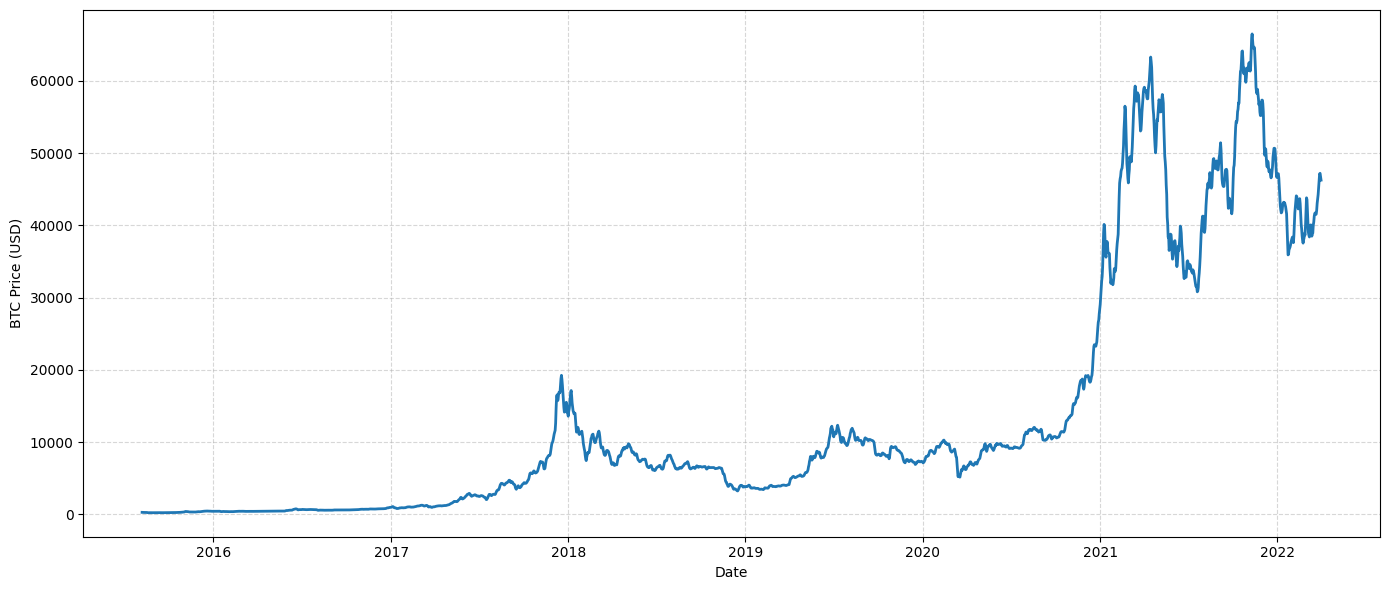

In [ ]:
#Time-Series plot of Bitcoin Price throughout entire dataset
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df.set_index('Date', inplace=True)

# Smooth BTC_Close with 3-day rolling average
df['BTC_Close'] = df['BTC_Close'].rolling(window=3).mean().bfill()

# Trim date range
df = df.loc["2015-08-07":"2022-04-1"]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['BTC_Close'], label='BTC_Close', linewidth=2)
plt.title("", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("btc_timeseries.png")  # Save to match document reference
plt.show()


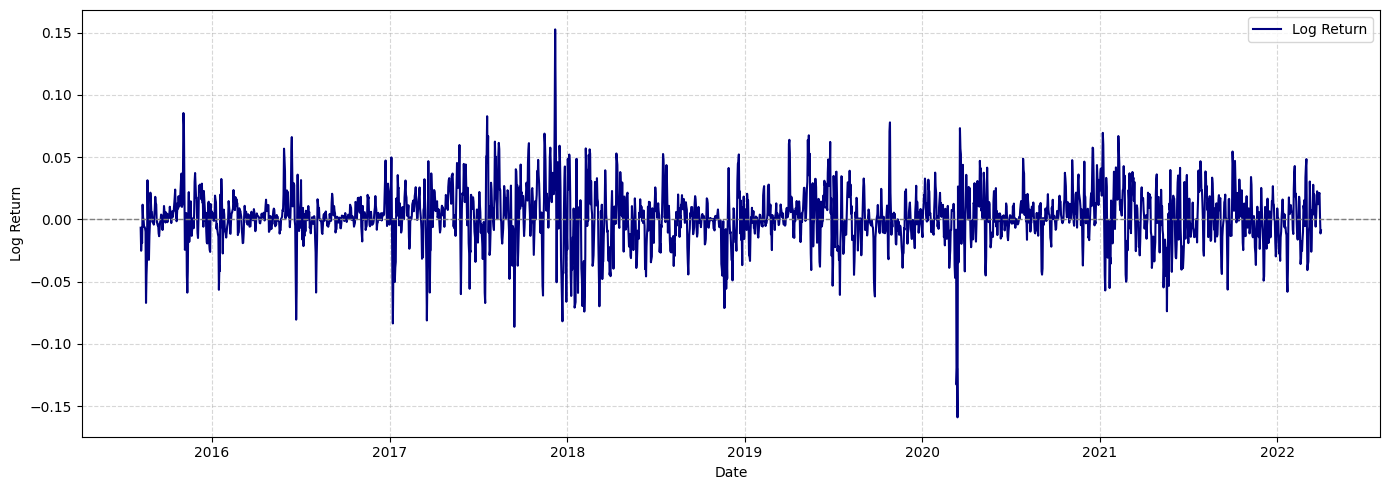

In [ ]:
#Log Returns Figure of daily price of Bitcoin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

# --- Load dataset ---
df = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df.set_index('Date', inplace=True)

# --- Smooth BTC_Close ---
df['BTC_Close'] = df['BTC_Close'].rolling(window=3).mean().bfill()

# --- Compute daily log returns ---
df['BTC_Log_Return'] = np.log(df['BTC_Close'] / df['BTC_Close'].shift(1))

# --- Filter date range ---
df = df.loc["2015-08-07":"2022-04-1"]

# --- Plot: Daily Log Returns ---
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['BTC_Log_Return'], color='navy', linewidth=1.5, label='Log Return')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.savefig("btc_log_returns.png")  # Optional: save the figure
plt.show()


<ipython-input-1-3c44a762d326>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_btc.values, y=corr_with_btc.index, palette=bar_colors)


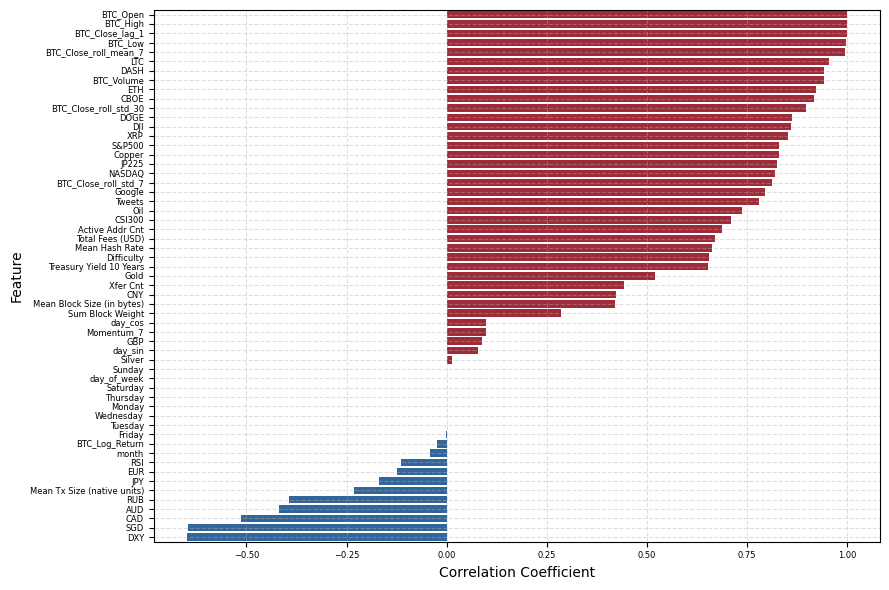

In [ ]:
#Correlation Figure of all variables on BTC_Close
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess dataset
df = pd.read_csv("https://raw.githubusercontent.com/shiitake-github/jrfm-2156907-data/main/jrfm-2156907.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df.set_index('Date', inplace=True)

df['BTC_Close'] = df['BTC_Close'].rolling(window=3).mean().bfill()
df['BTC_Log_Return'] = np.log(df['BTC_Close'] / df['BTC_Close'].shift(1))
df['BTC_Close_lag_1'] = df['BTC_Close'].shift(1)
df['BTC_Close_roll_mean_7'] = df['BTC_Close'].rolling(window=7).mean()
df['BTC_Close_roll_std_7'] = df['BTC_Close'].rolling(window=7).std()
df['BTC_Close_roll_std_30'] = df['BTC_Close'].rolling(window=30).std()
df['Momentum_7'] = df['BTC_Close'] - df['BTC_Close'].shift(7)

delta = df['BTC_Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

df = df.ffill().bfill()
df = df.loc["2015-08-07":"2018-09-30"]

# Correlation with BTC_Close
numeric_df = df.select_dtypes(include=[np.number])
corr_with_btc = numeric_df.corr()['BTC_Close'].drop('BTC_Close').sort_values(ascending=False)

# Plot - flipped color palette
plt.figure(figsize=(9, 6))
colors = sns.color_palette("coolwarm", as_cmap=True)
bar_colors = ['#b2182b' if val > 0 else '#2166ac' for val in corr_with_btc]

sns.barplot(x=corr_with_btc.values, y=corr_with_btc.index, palette=bar_colors)
plt.title("", fontsize=15, weight='bold')
plt.xlabel("Correlation Coefficient", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("btc_correlation_bar.png")
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Assuming df has already been processed as in your previous code...

# Select numeric features
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation with BTC_Close
corr_with_btc = numeric_df.corr()['BTC_Close'].drop('BTC_Close').sort_values(ascending=False)

# Create and display the table
corr_table = pd.DataFrame({
    'Feature': corr_with_btc.index,
    'Correlation with BTC_Close': corr_with_btc.values
})

print(corr_table.to_string(index=False))


                    Feature  Correlation with BTC_Close
                   BTC_Open                    0.999395
                   BTC_High                    0.999053
            BTC_Close_lag_1                    0.998920
                    BTC_Low                    0.998090
      BTC_Close_roll_mean_7                    0.995262
                        LTC                    0.953924
                       DASH                    0.941649
                 BTC_Volume                    0.941293
                        ETH                    0.921574
                       CBOE                    0.917168
      BTC_Close_roll_std_30                    0.897709
                       DOGE                    0.862577
                        DJI                    0.859711
                        XRP                    0.852773
                     S&P500                    0.830650
                     Copper                    0.828729
                      JP225                    0

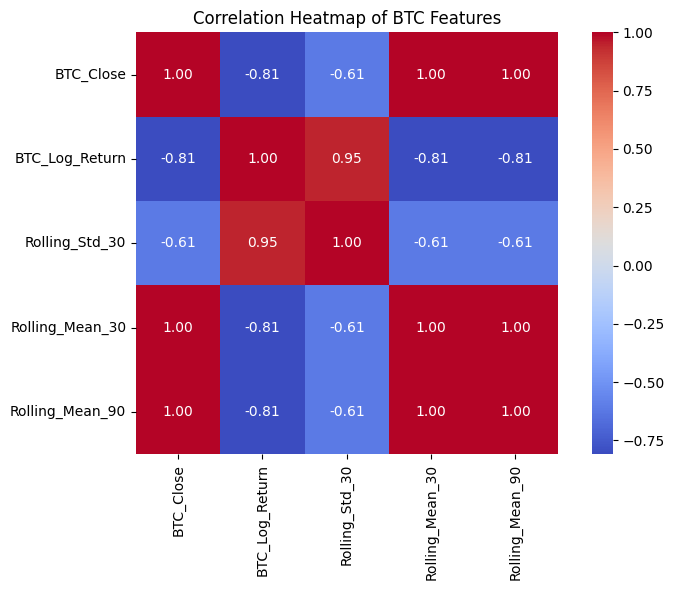

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate BTC data
np.random.seed(0)
dates = pd.date_range(start="2015-08-07", end="2018-09-30", freq='D')
sim_btc_close = np.cumsum(np.random.randn(len(dates)) * 20 + 1000)
sim_btc_log_return = np.log(sim_btc_close / np.roll(sim_btc_close, 1))
sim_btc_log_return[0] = 0

# Create DataFrame
sim_df = pd.DataFrame({
    'Date': dates,
    'BTC_Close': sim_btc_close,
    'BTC_Log_Return': sim_btc_log_return
})
sim_df.set_index('Date', inplace=True)

# Add rolling stats
sim_df['Rolling_Std_30'] = sim_df['BTC_Log_Return'].rolling(window=30).std()
sim_df['Rolling_Mean_30'] = sim_df['BTC_Close'].rolling(window=30).mean()
sim_df['Rolling_Mean_90'] = sim_df['BTC_Close'].rolling(window=90).mean()

# --------Correlation Heatmap--------
heatmap_data = sim_df[['BTC_Close', 'BTC_Log_Return', 'Rolling_Std_30', 'Rolling_Mean_30', 'Rolling_Mean_90']].dropna()
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of BTC Features")
plt.tight_layout()
plt.show()